In [386]:
import numpy as np
from astropy.io import ascii 
from astropy import units as u
import matplotlib.pyplot as plt
import random
import tqdm
from astropy.table import Table

In [401]:
#function for plot formatting
def plotting( title, x_title, y_title, show = True, myfontsize=15):
    plt.xticks(fontsize=myfontsize)
    plt.yticks(fontsize=myfontsize)
    plt.title(title, fontsize= myfontsize +2)
    plt.xlabel(x_title,fontsize=myfontsize)
    plt.ylabel(y_title,fontsize=myfontsize)
    if show:
        plt.show()


In [388]:
#reading in data to astropy table
with open('data.dat') as f:
    content = f.readlines()
    columns = [content[i].split(" ")[3] for i in range(2,5)]
    columns[1] = 'log10f'
    
data = ascii.read(content, data_start= 5, names = columns)  

#changing to cgs units:
λ = data['wavelength'].value * 10**(-4)
log10f = data['log10f'].value - 5

In [389]:
#defining constants in cgs units
hc = 6.63 * 10**(-27) * 3 * 10**10
k = 1.38 * 10**(-16)


In [390]:
data

wavelength,log10f,error
float64,float64,float64
3.368,-18.434868671490364,0.08685889638065036
4.618,-17.042091277264824,0.08685889638065036
12.082,-15.727551889037253,0.08685889638065036
22.194,-16.307417185997757,0.08685889638065036
3.6,-18.062510866962743,0.04342944819032518
4.5,-17.17263919421517,0.04342944819032518


In [391]:
def chi_square(residual, error):
    """Takes in the redisdual and error and returns the chi^2"""
    chi = np.dot(residual**2, 1/(error**2))
    return(chi)

$$
Δ\log(α) = - Δχ^2/2
$$

In [392]:
# model function to solve for log flux using parameters
model = lambda log_parameter, T: log_parameter - np.log10(λ**5 * (np.exp(hc / (λ * k * T)) - 1))


#likelihood calcuation 
log_likelihood_funct = lambda error, resid: - (0.5 * len(error) * np.log10(2 * np.pi)) - (np.sum( np.log10(error))) - 0.5 * np.dot(resid**2, 1/(error**2)) 


def log_like(calc_log_f, previous_chi, error = data['error'].value, data_log_f = log10f):
    """Input: calculated values of log(flux) calculated from a trial, chi^2 from previous trial, 
    assumes error is the error given in flux data and actual log flux is log flux in data
    Output: delta log likelihood, chi^2, and log liklihood"""
    
    residual = calc_log_f - data_log_f                      #calculates residual 
    chi = chi_square(residual, error)                       #calculates chi^2 
    log_likelihood  = log_likelihood_funct(error, residual) #log likelihood
    return (chi, log_likelihood)



IC = [log_parameter, T]

In [393]:
def step(IC, previous_chi, data_logf = log10f, data_error = data['error'].value):
    """
    Input:  values for T and log_parameter (IC), previous chi^2 from last step,
    optional parameters are flux data and error data
    
    Code plugs in T and log parameter values to caluclate the apprropriate flux and compares 
    it to the measured flux (in data) and error
    
    Output: Chi^2 and log(likilhood)
    """
    trial = model(IC[0], IC[1])
    chi, log_likelihood = log_like(trial, previous_chi) 
    
    return(chi, log_likelihood)
    
def log_prob_function(value, min_value, max_value):  #log(Π) for uniform probability 
    if min_value < value and value < max_value:
        return(0)   #log(1)
    else:
        return(-np.inf) # ≈log(0)

data_error = data['error'].value

#input all arrays
def mcmc(IC, trials, step_size):
    
    #setting up Initial conditions
    first_resid = model(IC[0], IC[1]) - log10f
    first_chi = chi_square(first_resid, data['error'])
    
    
    #making an astropy table of the values in each step
    arr = np.zeros((trials + 1, 4))
    step_table = Table(arr, names=('log_parameter', 'T', 'Chi2', 'log_Post'))
    
    
    step_table[0] = [IC[0], IC[1], first_chi, log_likelihood_funct(data_error, first_resid)]
    #can use log_likelihood as prior here because first guess should be in the uniform probablity area so that logΠ = 0
    
    step_taken = False
    
    for i in tqdm.tqdm(range(trials)):
        
        step_taken = False  
        
        #previous step information 
        previous_chi = step_table['Chi2'][i]
        previous_step = np.array([step_table['log_parameter'][i], step_table['T'][i]])
        previous_log_post = step_table['log_Post'][i]
       
        
        #false at the start of eah loop once a step accepted true to exit while loop 
        step_taken = False 
        while not step_taken:
        
            new_trial = previous_step + np.array([np.random.normal(0, step_size[0]), np.random.normal(0, step_size[1])])
            chi, log_likelihood = step(new_trial, previous_chi)
            
            log_Π = log_prob_function(new_trial[0], -np.inf, np.inf)+ log_prob_function(new_trial[1], 0.1, 3000) 
                #because log_parameter nuisance uniform prob but unbounded    
                #T must be greater than 0 K and less than 3000 K because this would be a star
            
            
            #no chance of being accepted as np.exp(-np.inf) = 0  just skips to next loop
            if log_Π == -np.inf: 
                continue
                   
            log_post = log_likelihood + log_Π
            
            
            if log_post > previous_log_post:
                step_table[i+1] = [new_trial[0], new_trial[1], chi, log_post]
                step_taken = True

            elif 10**(log_post - previous_log_post) > np.random.uniform(0,1):
                step_table[i+1] = [new_trial[0], new_trial[1], chi, log_post]
                step_taken = True  

                    

    return(step_table)





In [394]:
#runs mcmc
trial_num = 10**4
step_table = mcmc([-25, 1500], trial_num, np.array([3, 20]))

100%|█████████████████████████████████████| 10000/10000 [04:44<00:00, 35.17it/s]


In [395]:
#this calculates the end of burn in 
step_table
for i in range(len(step_table)):
    median = np.median(step_table['Chi2'][0:i])
    if step_table['Chi2'][i] > median:
        print(i)
        end_of_burn_in = i
        break

203


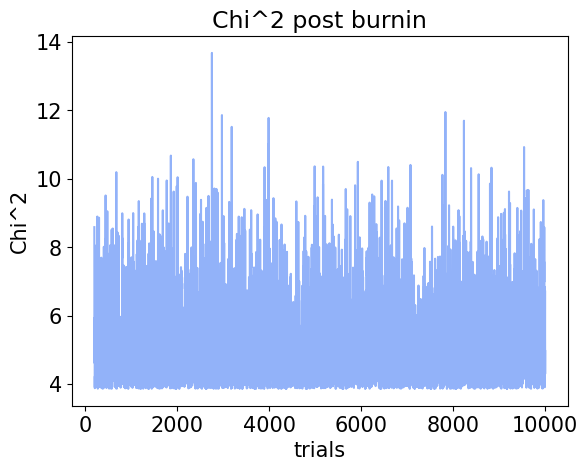

In [414]:
plt.plot([i for i in range(end_of_burn_in, trial_num+1)], step_table["Chi2"][end_of_burn_in:], color = '#92b2f9ff')

plt.title('Chi^2')
plotting('Chi^2 post burnin', "trials",'Chi^2')
    
    

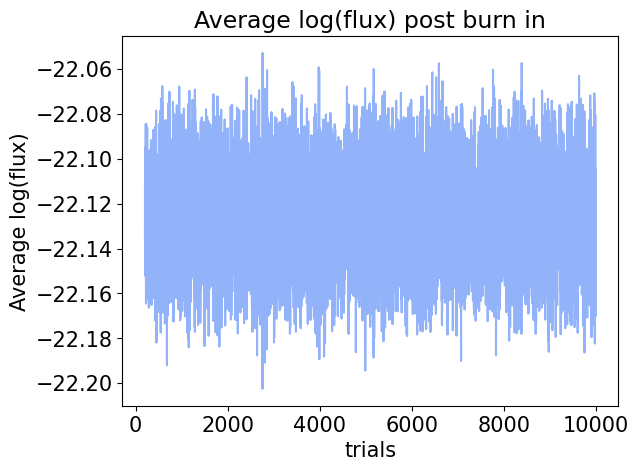

In [418]:
#plt.plot([i for i in range(trial_num+1)], model(step_table["T"], step_table["log_parameter"]))

#[model(step_table["T"][i], step_table["log_parameter"][i]) for i in range(len(step_table["log_parameter"]))]
 
T = step_table["T"][1]
lp = step_table["log_parameter"][1]

flux_calc = [np.average(model(step_table["log_parameter"][i], step_table["T"][i])) for i in range(len(step_table["log_parameter"]))]


plt.plot([i for i in range(end_of_burn_in, trial_num+1)], flux_calc[end_of_burn_in:], color = '#92b2f9ff')

plotting('Average log(flux) post burn in', "trials", 'Average log(flux)')

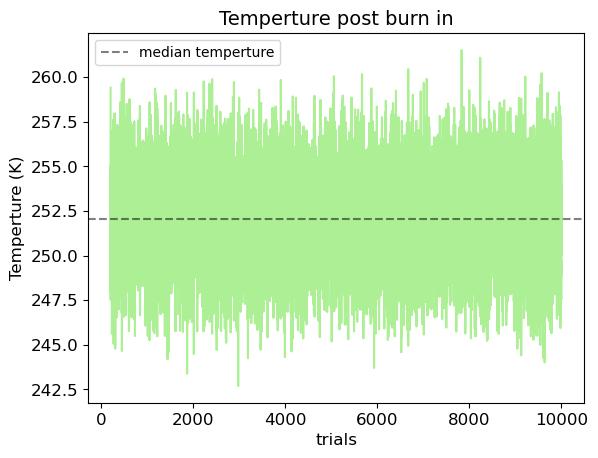

In [511]:
plt.plot([i for i in range(end_of_burn_in, trial_num+1)], step_table["T"][end_of_burn_in:], color = '#adef95ff')

plotting('Temperture post burn in', "trials", 'Temperture (K)', show = False, myfontsize=12)
plt.axhline(y=np.median(step_table["T"][end_of_burn_in:]), color='k', linestyle = '--', alpha =.5, label = 'median temperture')
plt.legend()
plt.savefig('Temp.pdf') 


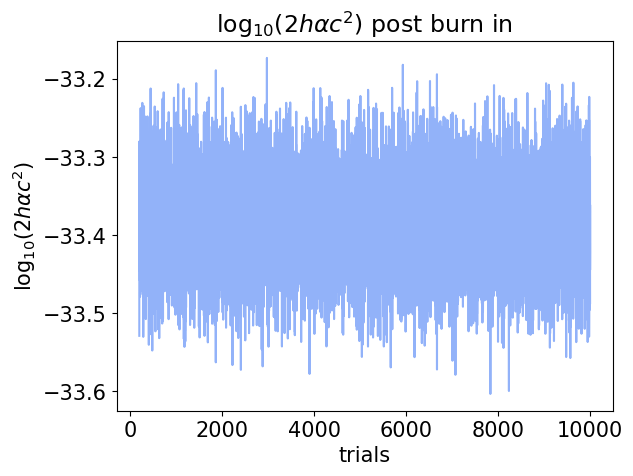

In [482]:
plt.plot([i for i in range(end_of_burn_in, trial_num+1)], step_table["log_parameter"][end_of_burn_in:], color = '#92b2f9ff')
plt.title('Log Parameter')
plotting(r'$\log_{10}(2hαc^2)$ post burn in', "trials", r'$\log_{10}(2hαc^2)$', show=False)
plt.savefig('logconst.pdf') 


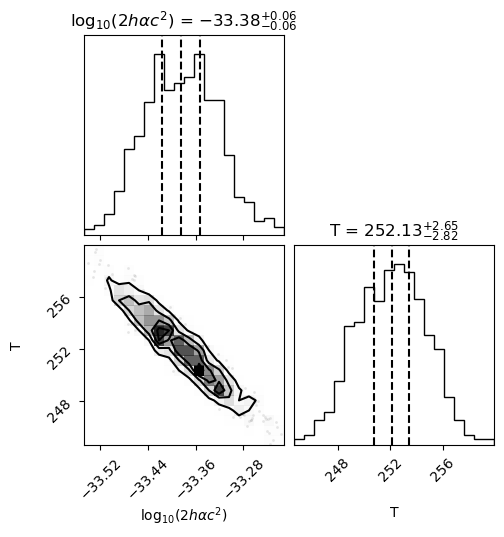

In [490]:
import corner
#creating corner plot
corner_list = np.array([(i["log_parameter"], i["T"]) for i in  step_table])


figure = corner.cornerfigure = corner.corner(
    corner_list[end_of_burn_in: 1000],
    labels=[
        r'$\log_{10}(2hαc^2)$',
        'T',
    ],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=(1- 0.67448, 0.5, 0.67448)
)
plt.savefig('corner.pdf') 
plt.show()

In [434]:
len(corner_list)

10001

$$
L_t/L_i = \exp(\log(L) - \log(L)) \\
log(L_t/L_i) = \log(L_t) - \log(L_i) \\
(L_t/L_i) = \exp(\log(L_t) - \log(L_i)) \\
P = L Π \\
Π = \text{prob of a prior}\\
\\
\log P = \log L + \log Π \\
P1/P2 = L1 * Π1 / (L2 * Π2) \\
\log(P2/P1) = \log(P2) -\log(P1) \\
= \log L2 + \log Π2 - \log L1 - \logΠ1
$$ 

$$
\log_{10}(f) = \log_{10}(2hαc^2) + \log_{10} \left( \frac{1}{λ^5} \frac{1}{ \text{exp}(\frac{hc}{λ k_B T}) -1} \right)
$$

Burn in using loglikehood > median 
uniform posterior 0-star
ans in slides: why normal likelihood, why mcmc

$$
    \log_{10} (\mathcal{P}) = \log_{10} (\mathcal{L}) + \log_{10} (\mathcal{Π})
$$

$$
\log_{10} (\mathcal{L}) = - \frac{1}{2}\sum_{i = 1}^N \log_{10}(2π) - \sum_{i = 1}^N \log_{10}(σ_i) - \frac{1}{2} χ^2
$$

$$
\log_{10} (\mathcal{Π}) =  
\left\{
    \begin{array}{lr}
        0 & T \in (0, 3000]\\
        \infty & T \notin (0, 3000]
    \end{array} \right\}
$$

$$
\log_{10} (\mathcal{P}_i) < \log_{10} (\mathcal{P}_{\text{trial}})\\
$$

$$
\frac{\mathcal{P}_{\text{trial}}}{\mathcal{P}_i} 
$$

$$
χ^2 > \text{Median }χ^2
$$

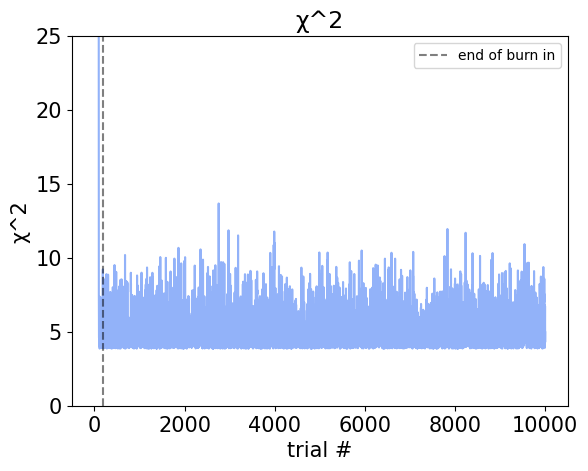

In [499]:
plt.plot([i for i in range(trial_num+1)], step_table["Chi2"], color = '#92b2f9ff')
plt.ylim( 0, 25)
plt.axvline(x=203, color='k', linestyle = '--', alpha =.5, label = 'end of burn in')
plt.title('Chi^2')
plt.legend()
plotting(r'χ^2', "trial #",r'χ^2', show = False)
plt.savefig('Chi_plot.pdf')  

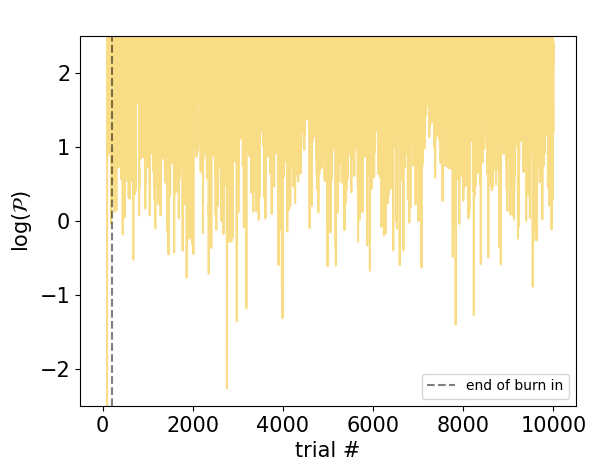

In [505]:
plt.plot([i for i in range(trial_num+1)], step_table["log_Prior"], color = '#f9dc86ff')
plt.axvline(x=203, color='k', linestyle = '--', alpha =.5, label = 'end of burn in')
plt.ylim(-2.5, 2.5)
plt.legend()
plotting(r' ', "trial #",r'$\log (\mathcal{P})$', show = False)
plt.savefig('posterior_plot.pdf')  